# CASO BANCO PAN 2024 - INSTRUÇÕES

### CONTEXTO

O Banco Pan, sempre buscando manter a excelência de seus processos e tomadas de decisão, está alterando a estratégia de concessão de cartão de crédito, e queremos maximizar nossa efetividade/rentabilidade em cima desse produto, avaliando oportunidades que possam otimizar o processo ´as is´.

### MISSÃO

Imagine que hoje você assuma uma posição dentro do Pan e precise verificar se existe algum score de crédito que poderia ser aproveitado pensando nesse cenário.  
  
Um score de crédito corresponde a um sistema de pontuação que classifica os consumidores em categorias de acordo com alguma variável (capacidade de pagamento, probabilidade de se tornar inadimplente etc.).  
  
Essa pontuação normalmente varia de 0 a 1000 e deveria ordenar a qualidade desse cliente.  


  


### INSTRUÇÃO GERAL

Te enviamos uma base que contém 5 scores variando de 0 a 1000, e 8 informações distintas, que podem ou não ter relação com os mesmos.  
  
Seu trabalho é propor uma solução com os scores que busquem maior efetividade para o produto. Não esqueça de utilizar modelagem.  
  
Você é livre para desenvolver em qualquer linguagem de programação, usando qualquer técnica, mas deverá desenvolver um modelo estatístico e elaborar uma apresentação com a solução proposta, de maneira que fique claro o que foi analisado, métricas, e a sua conclusão.  
  
Target alvo: **inadimpl_over30**  
  
  

### DICAS

Existe uma variavel que fala se a conta esta ativa ou não - pode avaliar como quiser, desde que faça sentido e bom senso, é justamente pra verificar o que você acha que 
seriam variáveis válidas.  
  
Envio: modelagem/códigos + ppt ou pdf - capriche, pode se prolongar no raciocínio, mesmo que a apresentação fique grande, lembre-se que é um único momento de validar com exatidão o seu conhecimento técnico no processo. E o case representa 60% do processo, você vai apresentar como se fosse um projeto.

# ANÁLISE E MODELAGEM

### Importação de pacotes e leitura dos dados ###

In [76]:
import numpy as np
import pandas as pd
import seaborn as sns 
import time
from datetime import datetime
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential
from keras.layers import Dense



2024-05-09 16:16:38.426735: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Caminho para o arquivo Excel
caminho_arquivo = 'CASE_CientistaDados_PAN_202404.xlsx'
planilha = 'data'

# Carregar o arquivo Excel em um DataFrame do pandas
xl = pd.read_excel(caminho_arquivo,sheet_name=planilha)

### Dando uma primeira olhada no arquivo

In [3]:
xl

Cliente  anomes  inadimpl_over30  fl_consig  fl_veiculos  \
0      1000000  202111                0          0            0   
1      1000001  202111                0          0            0   
2      1000002  202111                0          0            0   
3      1000003  202111                1          0            0   
4      1000004  202111                0          0            0   
...        ...     ...              ...        ...          ...   
18414  1018414  202111                0          0            0   
18415  1018415  202111                1          0            0   
18416  1018416  202111                0          0            0   
18417  1018417  202111                1          0            0   
18418  1018418  202111                1          0            0   

       flagcontaativabd  idade_serasa  renda  limite_cartao  \
0                     1            48  11150          640.0   
1                     1            19    900          150.0   
2                     0            33   1700         1220.0   
3                     1            23   1000          940.0   
4                     1            31   1150          700.0   
...                 ...           ...    ...            ...   
18414                 1            20   1200          290.0   
18415                 1            24    550          400.0   
18416                 1            40    950          590.0   
18417                 1            45   2450         1260.0   
18418                 1            24   2250         2400.0   

       vr_exposicao_total_cartao  score_h1  score_h2  score_h3  score_h4  \
0                          14.50       936       576       720       270   
1                         104.70       387       421       587       298   
2                         471.70       719       689       697       733   
3                         732.57       343       330       545       198   
4                         641.92       956       615       661       504   
...                          ...       ...       ...       ...       ...   
18414                     284.81       376       410       625       180   
18415                     438.10       298       213       418        86   
18416                     268.31       764       626       653       355   
18417                     331.10       639       486       602       746   
18418                    2135.91       497       641       492       222   

       score_h5  
0           511  
1           238  
2           457  
3           425  
4           565  
...         ...  
18414       354  
18415       199  
18416       449  
18417       473  
18418       216  

[18419 rows x 15 columns]

### Que colunas podemos descartar de imediato?

De imediato podemos excluir as seguintes colunas:  
  
- **Cliente** : campos de identificação não influem na modelagem.  
- **anomes** : apresenta o mesmo valor para todas as linhas, portanto pode ser descartado.  

In [4]:
xl.drop(['Cliente', 'anomes'], axis=1, inplace=True)

### Valores ausentes

In [5]:
print(xl.isna().sum())

inadimpl_over30              0
fl_consig                    0
fl_veiculos                  0
flagcontaativabd             0
idade_serasa                 0
renda                        0
limite_cartao                6
vr_exposicao_total_cartao    0
score_h1                     0
score_h2                     0
score_h3                     0
score_h4                     0
score_h5                     0
dtype: int64


Existem apenas 6 linhas com **limite_cartao** em branco. Podem ser clientes sem limite no cartão, ou os valores deixaram de ser cadastrados efetivamente. Como não temos elementos para concluir qual é o caso, e são poucas linhas, poderíamos excluir tais linhas. Mas vamos aguardar a análise da correlação das colunas. 

### Correlações entre variáveis independentes

**Primeira idéia:** montar um quadro de correlações para analisar como elas acontecem no dataframe. Para isso vamos normalizar seus valores para que se situem na mesma escala.

In [6]:
scaler = MinMaxScaler()

# Normalize todas as colunas do DataFrame
xl_norm = pd.DataFrame(scaler.fit_transform(xl), columns=xl.columns)

In [7]:
xl_norm

inadimpl_over30  fl_consig  fl_veiculos  flagcontaativabd  \
0                  0.0        0.0          0.0               1.0   
1                  0.0        0.0          0.0               1.0   
2                  0.0        0.0          0.0               0.0   
3                  1.0        0.0          0.0               1.0   
4                  0.0        0.0          0.0               1.0   
...                ...        ...          ...               ...   
18414              0.0        0.0          0.0               1.0   
18415              1.0        0.0          0.0               1.0   
18416              0.0        0.0          0.0               1.0   
18417              1.0        0.0          0.0               1.0   
18418              1.0        0.0          0.0               1.0   

       idade_serasa     renda  limite_cartao  vr_exposicao_total_cartao  \
0          0.564706  0.048818       0.010306                   0.000367   
1          0.223529  0.003940       0.001747                   0.002650   
2          0.388235  0.007443       0.020437                   0.011939   
3          0.270588  0.004378       0.015546                   0.018542   
4          0.364706  0.005035       0.011354                   0.016248   
...             ...       ...            ...                        ...   
18414      0.235294  0.005254       0.004192                   0.007209   
18415      0.282353  0.002408       0.006114                   0.011089   
18416      0.470588  0.004159       0.009432                   0.006791   
18417      0.529412  0.010727       0.021135                   0.008380   
18418      0.282353  0.009851       0.041048                   0.054063   

       score_h1  score_h2  score_h3  score_h4  score_h5  
0      0.935807  0.557629  0.712944  0.275299  0.587558  
1      0.385155  0.387486  0.574113  0.305767  0.273041  
2      0.718154  0.681668  0.688935  0.779108  0.525346  
3      0.341023  0.287596  0.530271  0.196953  0.488479  
4      0.955868  0.600439  0.651357  0.529924  0.649770  
...         ...       ...       ...       ...       ...  
18414  0.374122  0.375412  0.613779  0.177367  0.406682  
18415  0.295888  0.159166  0.397704  0.075082  0.228111  
18416  0.763290  0.612514  0.643006  0.367791  0.516129  
18417  0.637914  0.458836  0.589770  0.793254  0.543779  
18418  0.495486  0.628979  0.474948  0.223069  0.247696  

[18419 rows x 13 columns]

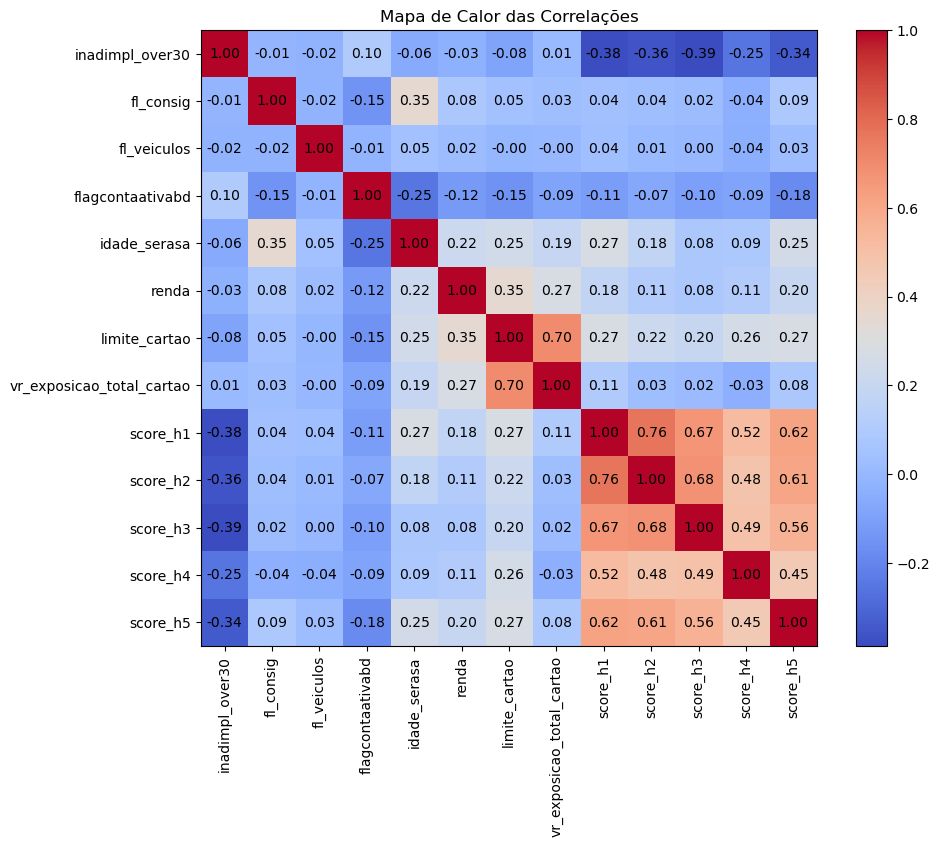

In [8]:
correlacoes = xl_norm.corr()

plt.figure(figsize=(10, 8))
plt.imshow(correlacoes, cmap='coolwarm', interpolation='nearest')

# Adicionar os valores das correlações nas células do mapa de calor
for i in range(len(correlacoes.columns)):
    for j in range(len(correlacoes.columns)):
        plt.text(j, i, f'{correlacoes.iloc[i, j]:.2f}', ha='center', va='center', color='black')

plt.colorbar()
plt.title('Mapa de Calor das Correlações')
plt.xticks(range(len(correlacoes.columns)), correlacoes.columns, rotation=90)
plt.yticks(range(len(correlacoes.columns)), correlacoes.columns)
plt.show()

/var/folders/lz/6kl6lw7s3pg9dmb1pkl7fdlw0000gn/T/ipykernel_3251/4180458596.py:1: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.set_option('mode.use_inf_as_na', True)
/Users/reinaldolepsch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/reinaldolepsch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/reinaldolepsch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

/Users/reinaldolepsch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/reinaldolepsch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/reinaldolepsch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/reinaldolepsch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

/Users/reinaldolepsch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/reinaldolepsch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/reinaldolepsch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/reinaldolepsch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

/Users/reinaldolepsch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/reinaldolepsch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/reinaldolepsch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/reinaldolepsch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

/Users/reinaldolepsch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/reinaldolepsch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/reinaldolepsch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/reinaldolepsch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

/Users/reinaldolepsch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/reinaldolepsch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/reinaldolepsch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/reinaldolepsch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

<Figure size 2000x900 with 0 Axes>

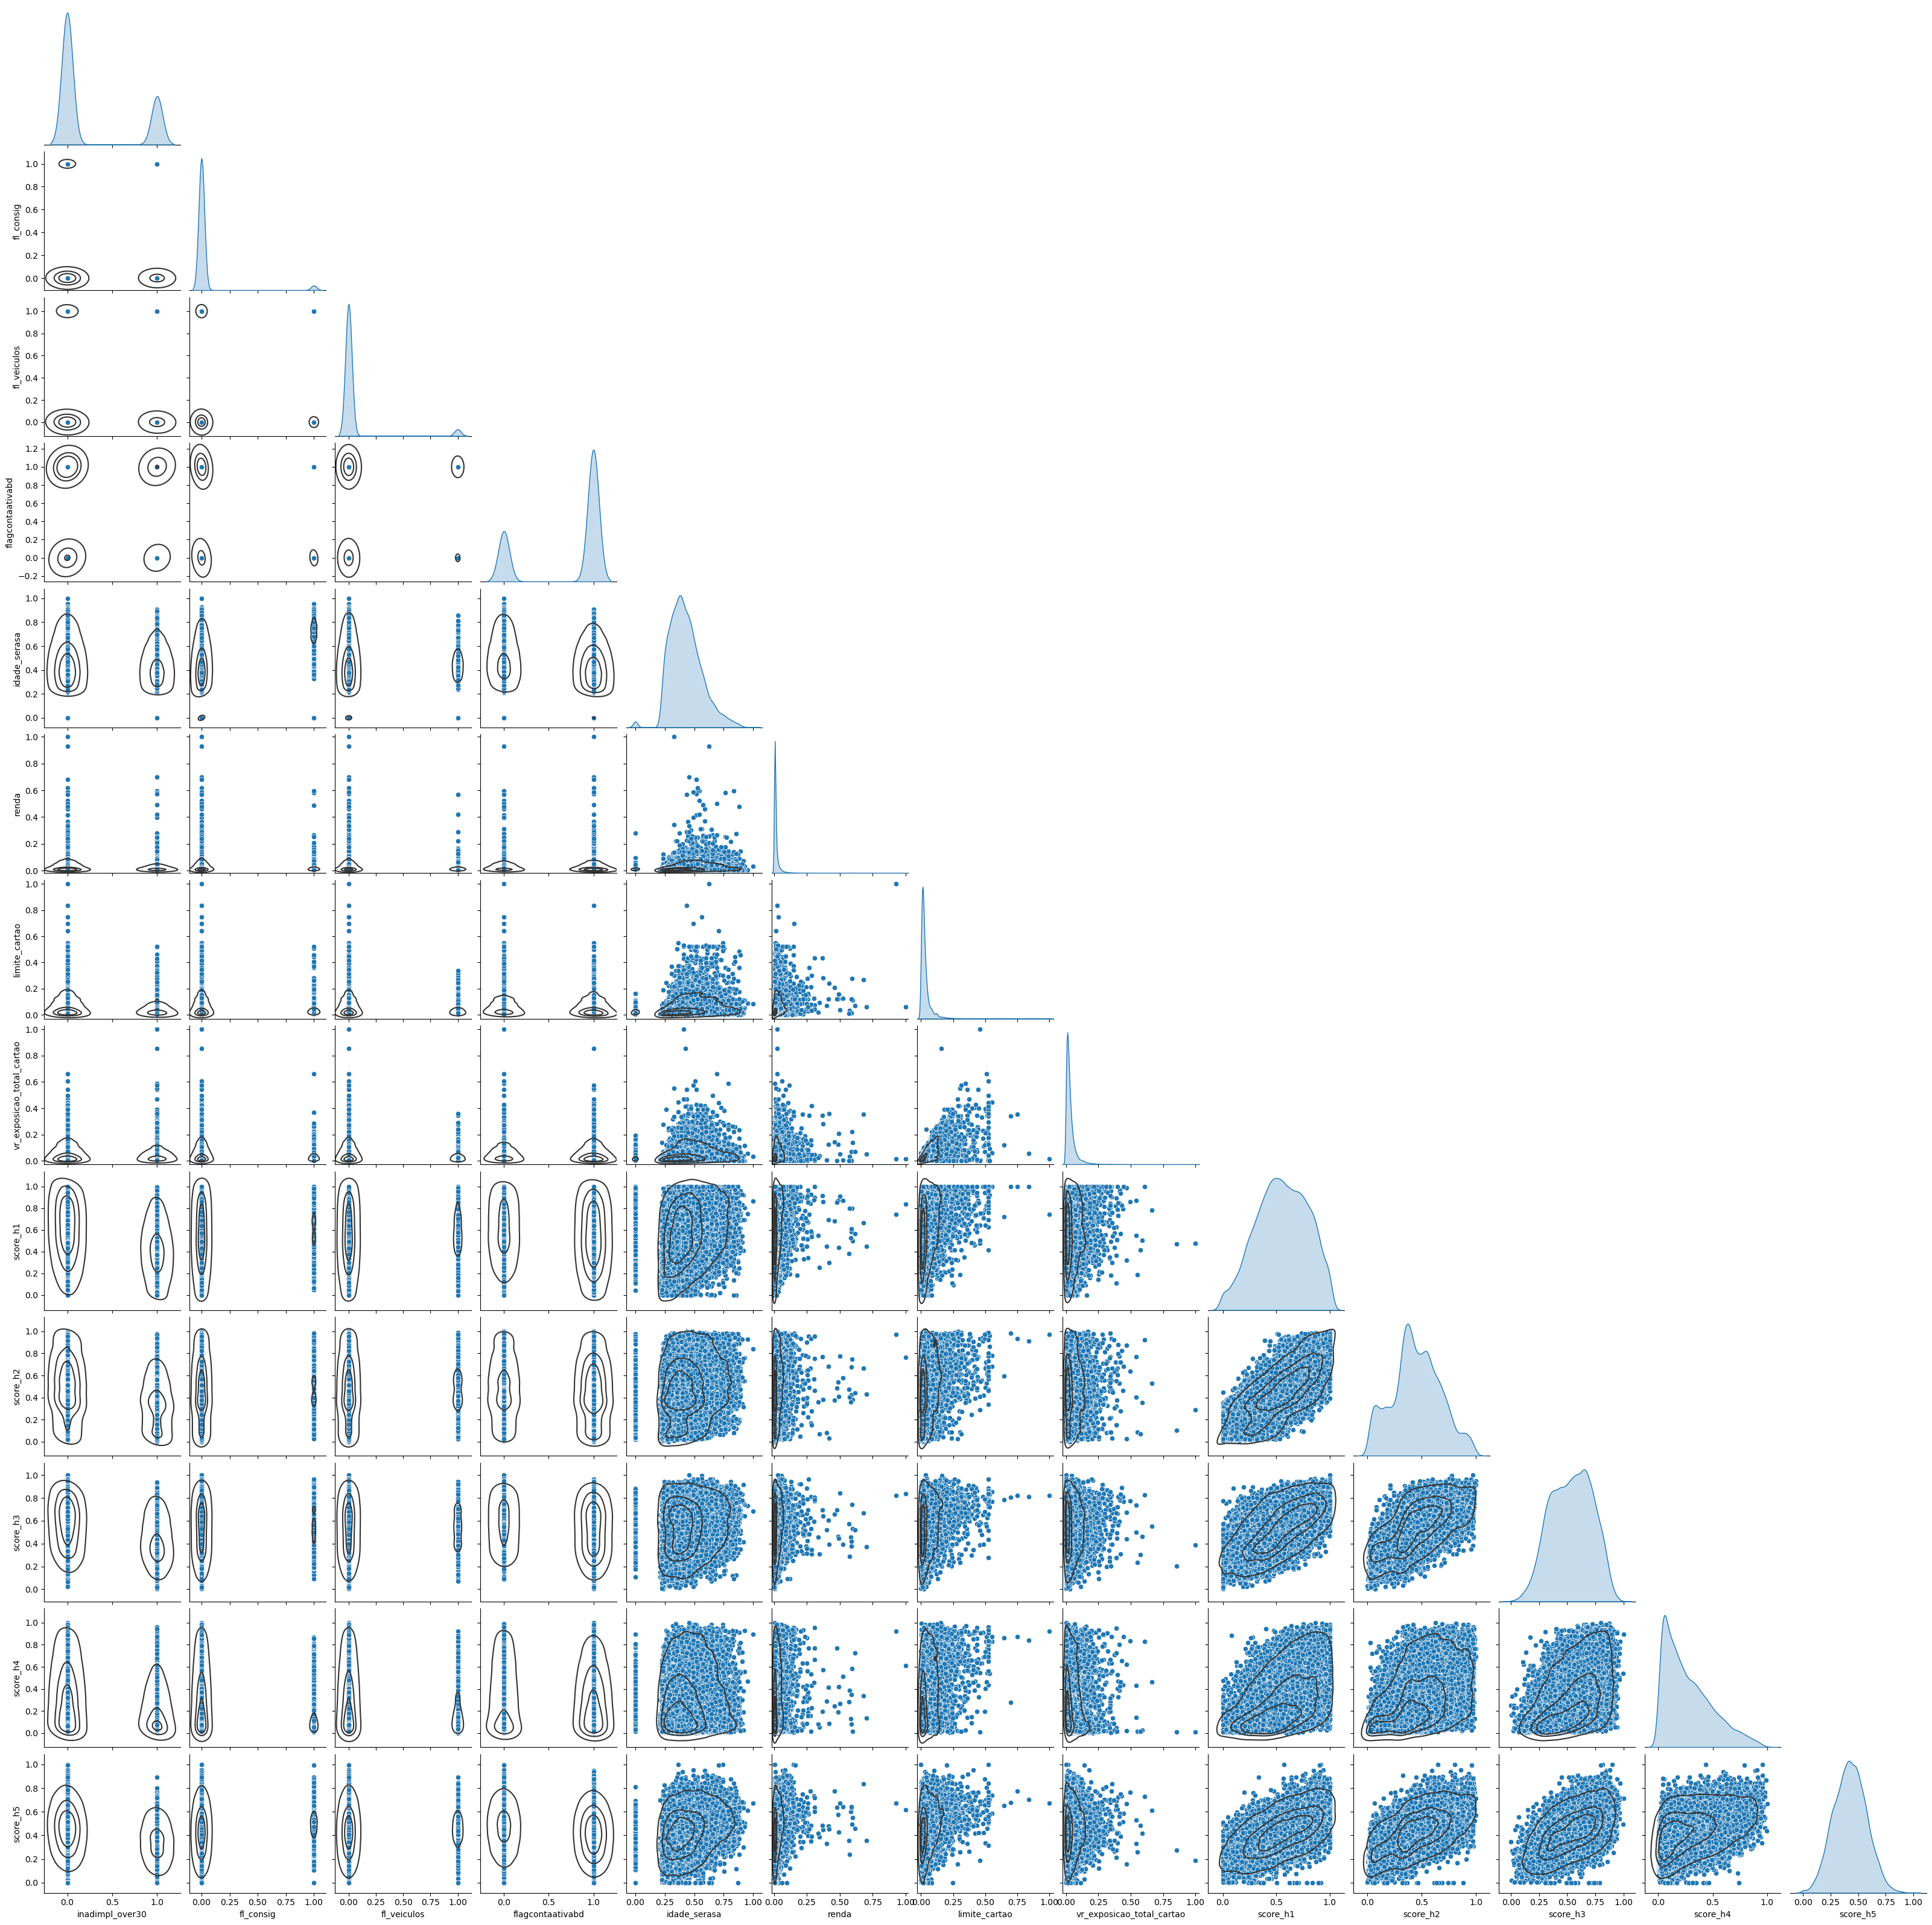

<Figure size 2000x900 with 0 Axes>

In [9]:
pd.set_option('mode.use_inf_as_na', True)
pd.option_context('mode.use_inf_as_na', True)

#-----CORRELATIONS
g = sns.pairplot(xl_norm,diag_kind="kde",corner=True)
g.map_lower(sns.kdeplot, levels=4, color=".2")
plt.figure(figsize=(20, 9))

**Vamos colocar a figura gerada acima aqui para visualizar por inteiro:**  

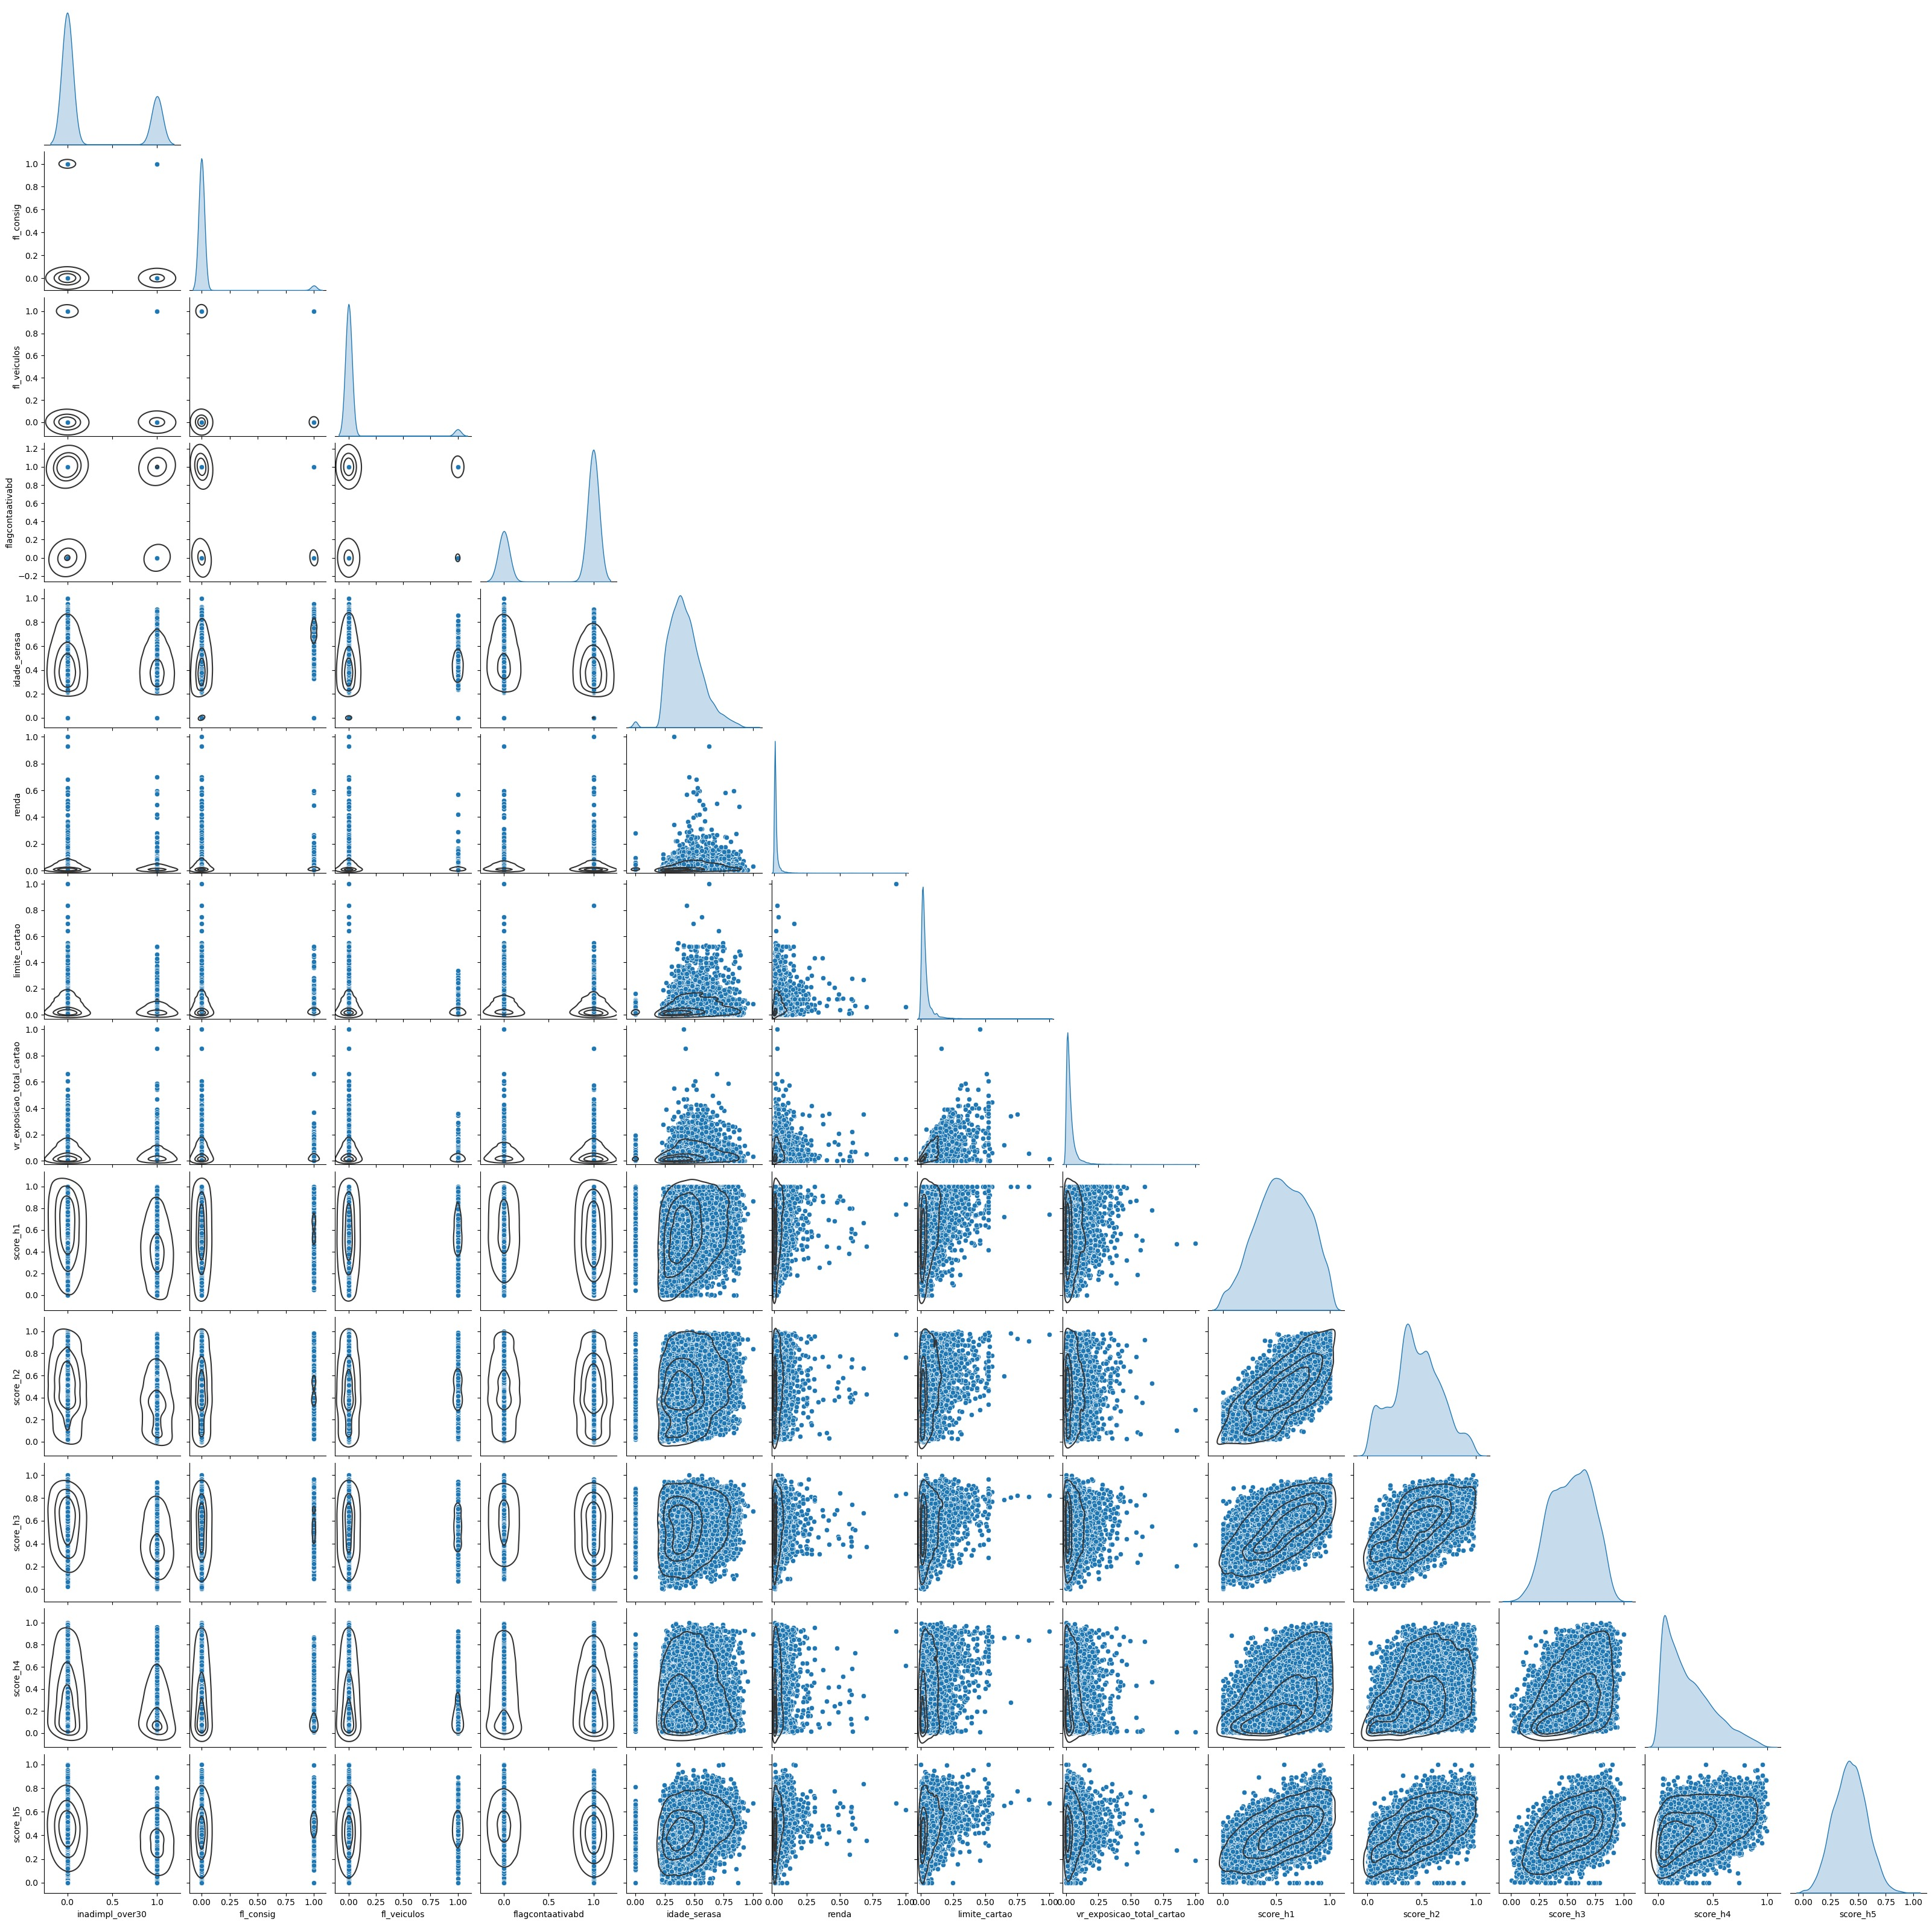

**Pelo mapa de calor e pelo mapa de correlações acima, podemos ver que:**
  
- as variáveis independentes seguem distribuições bem irregulares, talvez apenas o score **h5** se aproxima mais de uma distribuição normal.  
- as variáveis booleanas não acrescentam informação à análise.
- as quatro primeiras variáveis possuem correlação bem fraca com os scores.  
- os scores **h1, h2** e **h3** possuem correlação forte entre si.
- o score **h5** possui correlação moderada com **h1, h2** e **h3**.
- as variáveis independentes **limite_cartao, vr_exposicao_total_cartao** também possuem forte correlação entre si.

**Tomaremos a seguinte decisão:**  
  
- Excluiremos a variável independente **limite_cartao** por estar correlacionada com **vr_exposicao_total_cartao** (e também porque é aquela que possui valores faltantes).
- Excluiremos os scores **h2** e **h3** por estarem correlacionados com **h1** (moderadamente/forte).
- Num primeiro momento excluiremos também  o score **h5** por estar correlacionado (moderadamente) com **h1, h2** e **h3**.

In [10]:
xl_norm.drop(['limite_cartao','score_h2','score_h3','score_h5'], axis=1, inplace=True)

In [11]:
xl_norm

inadimpl_over30  fl_consig  fl_veiculos  flagcontaativabd  \
0                  0.0        0.0          0.0               1.0   
1                  0.0        0.0          0.0               1.0   
2                  0.0        0.0          0.0               0.0   
3                  1.0        0.0          0.0               1.0   
4                  0.0        0.0          0.0               1.0   
...                ...        ...          ...               ...   
18414              0.0        0.0          0.0               1.0   
18415              1.0        0.0          0.0               1.0   
18416              0.0        0.0          0.0               1.0   
18417              1.0        0.0          0.0               1.0   
18418              1.0        0.0          0.0               1.0   

       idade_serasa     renda  vr_exposicao_total_cartao  score_h1  score_h4  
0          0.564706  0.048818                   0.000367  0.935807  0.275299  
1          0.223529  0.003940                   0.002650  0.385155  0.305767  
2          0.388235  0.007443                   0.011939  0.718154  0.779108  
3          0.270588  0.004378                   0.018542  0.341023  0.196953  
4          0.364706  0.005035                   0.016248  0.955868  0.529924  
...             ...       ...                        ...       ...       ...  
18414      0.235294  0.005254                   0.007209  0.374122  0.177367  
18415      0.282353  0.002408                   0.011089  0.295888  0.075082  
18416      0.470588  0.004159                   0.006791  0.763290  0.367791  
18417      0.529412  0.010727                   0.008380  0.637914  0.793254  
18418      0.282353  0.009851                   0.054063  0.495486  0.223069  

[18419 rows x 9 columns]

## Estratégia de modelagem

A partir do dataframe acima, vamos criar modelos estatísticos comparando os dois scores que mantivemos: modelos utilizando Random Forest, Decision Tree, KNN, só score h1, só score h4, ou os dois scores.

In [12]:
def modelo_random_forest(df,features,target,ntrees=100):

    X = df[features] 
    y = df[target]    

    # Dividir os dados em conjuntos de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Construir o modelo de Random Forest para classificação binária
    model = RandomForestClassifier(n_estimators=ntrees, random_state=42)

    # Treinar o modelo usando massa de treinamento
    model.fit(X_train, y_train)

    # Avaliar o modelo usando massa de teste
    pred = model.predict(X_test)

    # Avaliar a precisão do modelo para classificação binária
    acc = accuracy_score(y_test, pred)
    print("Accuracy:", acc)

    # Relatório de classificação
    print("Relatório de classificação:")
    print(classification_report(y_test, pred))

    # Matriz de confusão
    print("Matriz de confusão:")
    print(confusion_matrix(y_test, pred))
    
    return

In [13]:
target = 'inadimpl_over30'
features = ['fl_consig','fl_veiculos','flagcontaativabd',
            'idade_serasa','renda','vr_exposicao_total_cartao','score_h1']

modelo_random_forest(xl_norm,features,target,100)

Accuracy: 0.7274701411509229
Relatório de classificação:
              precision    recall  f1-score   support

         0.0       0.77      0.89      0.83      2670
         1.0       0.51      0.29      0.37      1014

    accuracy                           0.73      3684
   macro avg       0.64      0.59      0.60      3684
weighted avg       0.70      0.73      0.70      3684

Matriz de confusão:
[[2388  282]
 [ 722  292]]


In [14]:
features = ['fl_consig','fl_veiculos','flagcontaativabd',
            'idade_serasa','renda','vr_exposicao_total_cartao','score_h4']

modelo_random_forest(xl_norm,features,target,100)

Accuracy: 0.7054831704668838
Relatório de classificação:
              precision    recall  f1-score   support

         0.0       0.74      0.91      0.82      2670
         1.0       0.42      0.17      0.24      1014

    accuracy                           0.71      3684
   macro avg       0.58      0.54      0.53      3684
weighted avg       0.65      0.71      0.66      3684

Matriz de confusão:
[[2425  245]
 [ 840  174]]


In [15]:
features = ['fl_consig','fl_veiculos','flagcontaativabd',
            'idade_serasa','renda','vr_exposicao_total_cartao','score_h1']

modelo_random_forest(xl_norm,features,target,500)

Accuracy: 0.7301845819761129
Relatório de classificação:
              precision    recall  f1-score   support

         0.0       0.77      0.90      0.83      2670
         1.0       0.52      0.29      0.37      1014

    accuracy                           0.73      3684
   macro avg       0.64      0.59      0.60      3684
weighted avg       0.70      0.73      0.70      3684

Matriz de confusão:
[[2397  273]
 [ 721  293]]


In [16]:
features = ['fl_consig','fl_veiculos','flagcontaativabd',
            'idade_serasa','renda','vr_exposicao_total_cartao','score_h1']

modelo_random_forest(xl_norm,features,target,10000)

Accuracy: 0.7290988056460369
Relatório de classificação:
              precision    recall  f1-score   support

         0.0       0.77      0.90      0.83      2670
         1.0       0.51      0.29      0.37      1014

    accuracy                           0.73      3684
   macro avg       0.64      0.59      0.60      3684
weighted avg       0.70      0.73      0.70      3684

Matriz de confusão:
[[2393  277]
 [ 721  293]]


In [17]:
features = ['fl_consig','fl_veiculos','flagcontaativabd',
            'idade_serasa','renda','vr_exposicao_total_cartao','score_h1']

modelo_random_forest(xl_norm,features,target,10)

Accuracy: 0.7163409337676439
Relatório de classificação:
              precision    recall  f1-score   support

         0.0       0.76      0.89      0.82      2670
         1.0       0.47      0.26      0.33      1014

    accuracy                           0.72      3684
   macro avg       0.62      0.57      0.58      3684
weighted avg       0.68      0.72      0.69      3684

Matriz de confusão:
[[2378  292]
 [ 753  261]]


In [21]:
def modelo_decision_tree(df,features,target):
    
    X = df[features] 
    y = df[target]
    
    # dividir os dados em conjuntos de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # construir o modelo de árvore de decisão para classificação binária
    model = DecisionTreeClassifier(random_state=42)

    # treinar o modelo
    model.fit(X_train, y_train)

    # avaliar o modelo
    pred = model.predict(X_test)

    # Avalie a precisão do modelo
    acc = accuracy_score(y_test, pred)
    print("Accuracy:", acc)

    # Exiba um relatório de classificação
    print("Relatório de classificação:")
    print(classification_report(y_test, pred))

    # Exiba a matriz de confusão
    print("Matriz de confusão:")
    print(confusion_matrix(y_test, pred))

In [22]:
features = ['fl_consig','fl_veiculos','flagcontaativabd',
            'idade_serasa','renda','vr_exposicao_total_cartao','score_h1']

modelo_decision_tree(xl_norm,features,target)

Accuracy: 0.6674809989142236
Relatório de classificação:
              precision    recall  f1-score   support

         0.0       0.77      0.77      0.77      2670
         1.0       0.39      0.39      0.39      1014

    accuracy                           0.67      3684
   macro avg       0.58      0.58      0.58      3684
weighted avg       0.67      0.67      0.67      3684

Matriz de confusão:
[[2065  605]
 [ 620  394]]


In [23]:
features = ['fl_consig','fl_veiculos','flagcontaativabd',
            'idade_serasa','renda','vr_exposicao_total_cartao','score_h4']

modelo_decision_tree(xl_norm,features,target)

Accuracy: 0.6254071661237784
Relatório de classificação:
              precision    recall  f1-score   support

         0.0       0.74      0.74      0.74      2670
         1.0       0.32      0.32      0.32      1014

    accuracy                           0.63      3684
   macro avg       0.53      0.53      0.53      3684
weighted avg       0.63      0.63      0.63      3684

Matriz de confusão:
[[1975  695]
 [ 685  329]]


In [24]:
features = ['fl_consig','fl_veiculos','flagcontaativabd',
            'idade_serasa','renda','vr_exposicao_total_cartao','score_h1']

modelo_decision_tree(xl_norm,features,target)

Accuracy: 0.6674809989142236
Relatório de classificação:
              precision    recall  f1-score   support

         0.0       0.77      0.77      0.77      2670
         1.0       0.39      0.39      0.39      1014

    accuracy                           0.67      3684
   macro avg       0.58      0.58      0.58      3684
weighted avg       0.67      0.67      0.67      3684

Matriz de confusão:
[[2065  605]
 [ 620  394]]


In [25]:
features = ['fl_consig','fl_veiculos','flagcontaativabd',
            'idade_serasa','renda','vr_exposicao_total_cartao','score_h1','score_h4']

modelo_random_forest(xl_norm,features,target,500)

Accuracy: 0.742399565689468
Relatório de classificação:
              precision    recall  f1-score   support

         0.0       0.78      0.91      0.84      2670
         1.0       0.56      0.31      0.40      1014

    accuracy                           0.74      3684
   macro avg       0.67      0.61      0.62      3684
weighted avg       0.72      0.74      0.71      3684

Matriz de confusão:
[[2425  245]
 [ 704  310]]


### Vamos colocar o modelo numa procedure, para utiliza-lo com diferentes parâmetros

In [26]:
def modelo_random_forest(df,features,target,ntrees):

    X = df[features] 
    y = df[target]    

    # Dividir os dados em conjuntos de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Construir o modelo de Random Forest para classificação binária
    model = RandomForestClassifier(n_estimators=ntrees, random_state=42)

    # Treinar o modelo usando massa de treinamento
    model.fit(X_train, y_train)

    # Avaliar o modelo usando massa de teste
    pred = model.predict(X_test)

    # Avaliar a precisão do modelo para classificação binária
    acc = accuracy_score(y_test, pred)
    
    return acc

In [35]:
def mostra_data_hora_atual():
    agora = datetime.now()
    data_hora_atual = agora.strftime("%Y-%m-%d %H:%M:%S")
    return data_hora_atual

In [32]:
def format_tempo(segundos):
    horas = segundos // 3600
    minutos = (segundos % 3600) // 60
    segundos = segundos % 60

    return "{:02d}:{:02d}:{:02d}".format(int(horas), int(minutos), int(segundos))


In [38]:
def format_duracao(segundos):
    horas = segundos // 3600
    minutos = (segundos % 3600) // 60
    segundos = segundos % 60

    return "{:02d} hr {:02d} min {:02d} seg".format(int(horas), int(minutos), int(segundos))

********************************************************************************
 AVALIAÇÃO DE MODELOS COM RANDOM FOREST 
********************************************************************************

*** INÍCIO PROCESSAMENTO :  2024-05-09 11:40:27


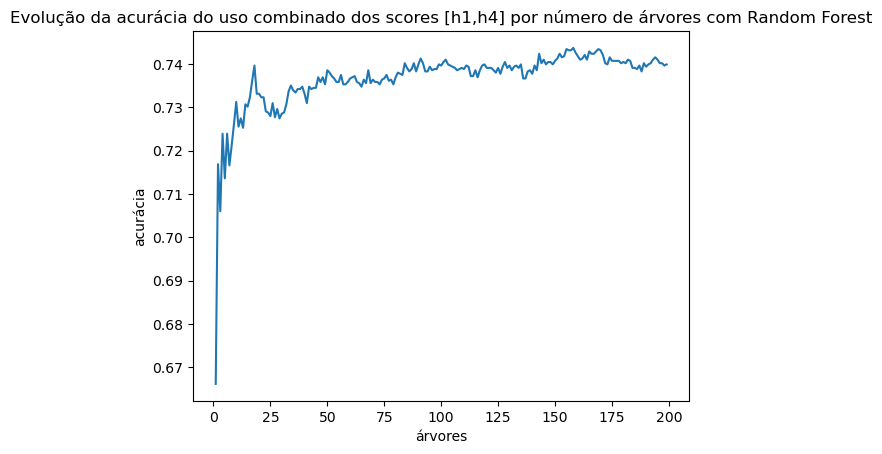

**** FIM PROCESSAMENTO :  2024-05-09 11:47:08
**** TEMPO DE PROCESSAMENTO      :  00 hr 06 min 40 seg
>>>> Melhor acurácia             :  0.743756786102063  --- para  158  árvores.


In [41]:
features = ['fl_consig','fl_veiculos','flagcontaativabd',
            'idade_serasa','renda','vr_exposicao_total_cartao','score_h1','score_h4']

valX = []
valY = []
maxt = 200

ti = time.time()
print("*" * 80)
print(" AVALIAÇÃO DE MODELOS COM RANDOM FOREST ")
print("*" * 80)
print("\n*** INÍCIO PROCESSAMENTO : ",mostra_data_hora_atual())

for nt in range(1,maxt):
    acc = modelo_random_forest(xl_norm,features,target,nt)
    valX.append(nt)
    valY.append(acc)
    
    
# Plotar o gráfico de linha
plt.plot(valX, valY)

# Adicionar rótulos aos eixos
plt.xlabel('árvores')
plt.ylabel('acurácia')

# Adicionar título ao gráfico
plt.title('Evolução da acurácia do uso combinado dos scores [h1,h4] por número de árvores com Random Forest')

# Mostrar o gráfico
plt.show() 

tf = time.time()
print("**** FIM PROCESSAMENTO : ",mostra_data_hora_atual())
print("**** TEMPO DE PROCESSAMENTO      : ", format_duracao(tf-ti))
print(">>>> Melhor acurácia             : ", np.max(valY), " --- para ",valX[np.argmax(valY)]," árvores.")

********************************************************************************
 AVALIAÇÃO DE MODELOS COM RANDOM FOREST 
********************************************************************************

*** INÍCIO PROCESSAMENTO :  2024-05-09 14:51:37


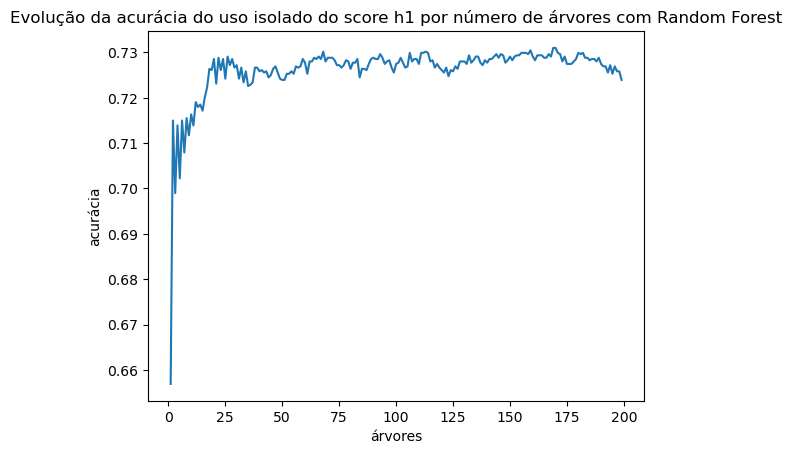

**** FIM PROCESSAMENTO :  2024-05-09 14:57:16
**** TEMPO DE PROCESSAMENTO      :  00 hr 05 min 38 seg
>>>> Melhor acurácia             :  0.7309989142236699  --- para  169  árvores.


In [73]:
features = ['fl_consig','fl_veiculos','flagcontaativabd',
            'idade_serasa','renda','vr_exposicao_total_cartao','score_h1']

valX = []
valY = []
maxt = 200

ti = time.time()
print("*" * 80)
print(" AVALIAÇÃO DE MODELOS COM RANDOM FOREST ")
print("*" * 80)
print("\n*** INÍCIO PROCESSAMENTO : ",mostra_data_hora_atual())

for nt in range(1,maxt):
    acc = modelo_random_forest(xl_norm,features,target,nt)
    valX.append(nt)
    valY.append(acc)
    
    
# Plotar o gráfico de linha
plt.plot(valX, valY)

# Adicionar rótulos aos eixos
plt.xlabel('árvores')
plt.ylabel('acurácia')

# Adicionar título ao gráfico
plt.title('Evolução da acurácia do uso isolado do score h1 por número de árvores com Random Forest')

# Mostrar o gráfico
plt.show() 

tf = time.time()
print("**** FIM PROCESSAMENTO : ",mostra_data_hora_atual())
print("**** TEMPO DE PROCESSAMENTO      : ", format_duracao(tf-ti))
print(">>>> Melhor acurácia             : ", np.max(valY), " --- para ",valX[np.argmax(valY)]," árvores.")

********************************************************************************
 AVALIAÇÃO DE MODELOS COM RANDOM FOREST 
********************************************************************************

*** INÍCIO PROCESSAMENTO :  2024-05-09 15:00:10


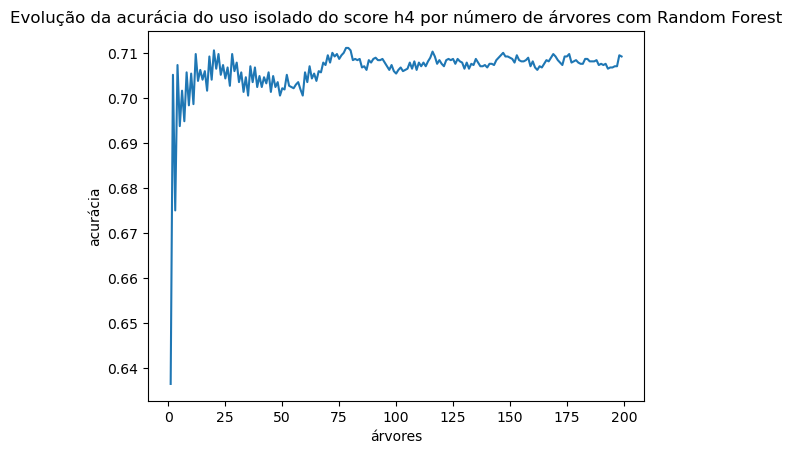

**** FIM PROCESSAMENTO :  2024-05-09 15:06:08
**** TEMPO DE PROCESSAMENTO      :  00 hr 05 min 58 seg
>>>> Melhor acurácia             :  0.7111834961997828  --- para  78  árvores.


In [74]:
features = ['fl_consig','fl_veiculos','flagcontaativabd',
            'idade_serasa','renda','vr_exposicao_total_cartao','score_h4']

valX = []
valY = []
maxt = 200

ti = time.time()
print("*" * 80)
print(" AVALIAÇÃO DE MODELOS COM RANDOM FOREST ")
print("*" * 80)
print("\n*** INÍCIO PROCESSAMENTO : ",mostra_data_hora_atual())

for nt in range(1,maxt):
    acc = modelo_random_forest(xl_norm,features,target,nt)
    valX.append(nt)
    valY.append(acc)
    
    
# Plotar o gráfico de linha
plt.plot(valX, valY)

# Adicionar rótulos aos eixos
plt.xlabel('árvores')
plt.ylabel('acurácia')

# Adicionar título ao gráfico
plt.title('Evolução da acurácia do uso isolado do score h4 por número de árvores com Random Forest')

# Mostrar o gráfico
plt.show() 

tf = time.time()
print("**** FIM PROCESSAMENTO : ",mostra_data_hora_atual())
print("**** TEMPO DE PROCESSAMENTO      : ", format_duracao(tf-ti))
print(">>>> Melhor acurácia             : ", np.max(valY), " --- para ",valX[np.argmax(valY)]," árvores.")

## Melhorias

Vamos tentar melhorar a acurácia utilizando dois outros modelos: **SVM** e **KNN**. Manteremos a melhor configuração de scores obtida acima (**h1** e **h4** utilizados simultaneamente).

In [57]:
def modelo_svm(df,features,target,k='linear'):

    X = df[features] 
    y = df[target]    

    # Dividir os dados em conjuntos de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Construir o modelo de SVM para classificação binária
    model = svm.SVC(kernel=k)

    # Treinar o modelo usando massa de treinamento
    model.fit(X_train, y_train)

    # Avaliar o modelo usando massa de teste
    pred = model.predict(X_test)

    # Avaliar a precisão do modelo para classificação binária
    acc = accuracy_score(y_test, pred)
    
    return acc

********************************************************************************
 AVALIAÇÃO DE MODELO COM SVM - Scores h1 e h4
********************************************************************************

*** INÍCIO PROCESSAMENTO :  2024-05-09 12:08:42


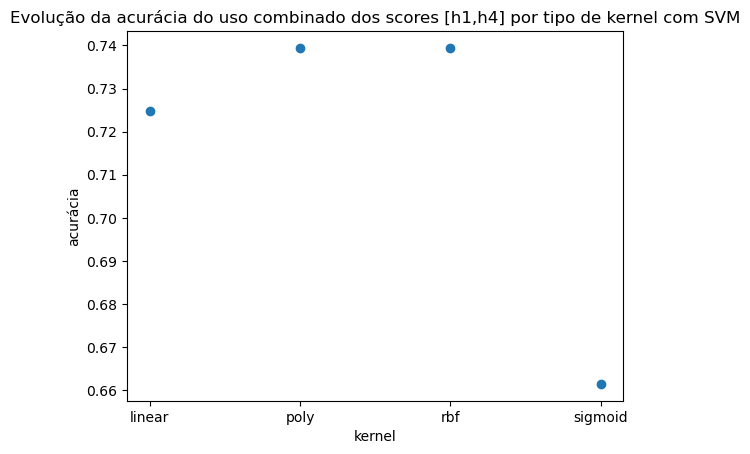

**** FIM PROCESSAMENTO :  2024-05-09 12:09:07
**** TEMPO DE PROCESSAMENTO      :  00 hr 00 min 24 seg
>>>> Melhor acurácia             :  0.739413680781759  --- para kernel  poly


In [59]:
features = ['fl_consig','fl_veiculos','flagcontaativabd',
            'idade_serasa','renda','vr_exposicao_total_cartao','score_h1','score_h4']

valX = []
valY = []

ti = time.time()
print("*" * 80)
print(" AVALIAÇÃO DE MODELO COM SVM - Scores h1 e h4")
print("*" * 80)
print("\n*** INÍCIO PROCESSAMENTO : ",mostra_data_hora_atual())

for k in ['linear','poly','rbf','sigmoid']:
    acc = modelo_svm(xl_norm,features,target,k)
    valX.append(k)
    valY.append(acc)
    #print("Acurácia para kernel=",k,": ",acc)

# Plotar o gráfico de linha
plt.scatter(valX, valY)

# Adicionar rótulos aos eixos
plt.xlabel('kernel')
plt.ylabel('acurácia')

# Adicionar título ao gráfico
plt.title('Evolução da acurácia do uso combinado dos scores [h1,h4] por tipo de kernel com SVM')

# Mostrar o gráfico
plt.show()
    
tf = time.time()
print("**** FIM PROCESSAMENTO : ",mostra_data_hora_atual())
print("**** TEMPO DE PROCESSAMENTO      : ", format_duracao(tf-ti))
print(">>>> Melhor acurácia             : ", np.max(valY), " --- para kernel ",valX[np.argmax(valY)])

********************************************************************************
 AVALIAÇÃO DE MODELO COM SVM - Score h1
********************************************************************************

*** INÍCIO PROCESSAMENTO :  2024-05-09 12:16:11


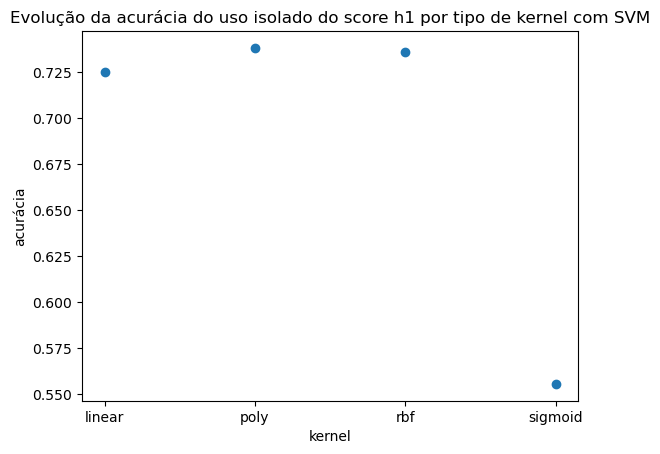

**** FIM PROCESSAMENTO :  2024-05-09 12:16:34
**** TEMPO DE PROCESSAMENTO      :  00 hr 00 min 23 seg
>>>> Melhor acurácia             :  0.738056460369164  --- para kernel  poly


In [60]:
features = ['fl_consig','fl_veiculos','flagcontaativabd',
            'idade_serasa','renda','vr_exposicao_total_cartao','score_h1']

valX = []
valY = []

ti = time.time()
print("*" * 80)
print(" AVALIAÇÃO DE MODELO COM SVM - Score h1")
print("*" * 80)
print("\n*** INÍCIO PROCESSAMENTO : ",mostra_data_hora_atual())

for k in ['linear','poly','rbf','sigmoid']:
    acc = modelo_svm(xl_norm,features,target,k)
    valX.append(k)
    valY.append(acc)
    #print("Acurácia para kernel=",k,": ",acc)

# Plotar o gráfico de linha
plt.scatter(valX, valY)

# Adicionar rótulos aos eixos
plt.xlabel('kernel')
plt.ylabel('acurácia')

# Adicionar título ao gráfico
plt.title('Evolução da acurácia do uso isolado do score h1 por tipo de kernel com SVM')

# Mostrar o gráfico
plt.show()
    
tf = time.time()
print("**** FIM PROCESSAMENTO : ",mostra_data_hora_atual())
print("**** TEMPO DE PROCESSAMENTO      : ", format_duracao(tf-ti))
print(">>>> Melhor acurácia             : ", np.max(valY), " --- para kernel ",valX[np.argmax(valY)])

********************************************************************************
 AVALIAÇÃO DE MODELO COM SVM - Score h4
********************************************************************************

*** INÍCIO PROCESSAMENTO :  2024-05-09 12:20:18


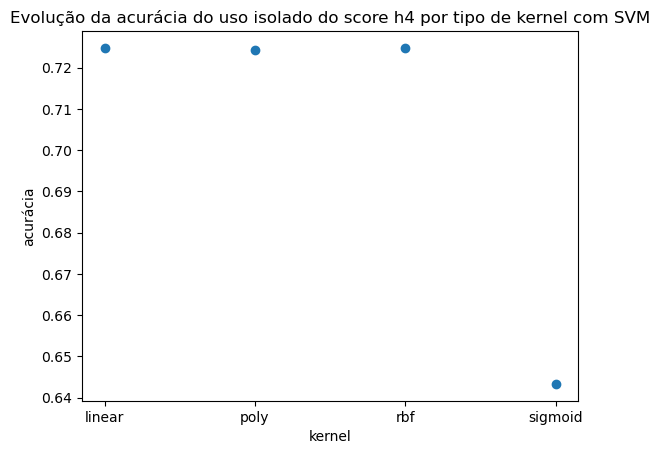

**** FIM PROCESSAMENTO :  2024-05-09 12:20:51
**** TEMPO DE PROCESSAMENTO      :  00 hr 00 min 33 seg
>>>> Melhor acurácia             :  0.7247557003257329  --- para kernel  linear


In [61]:
features = ['fl_consig','fl_veiculos','flagcontaativabd',
            'idade_serasa','renda','vr_exposicao_total_cartao','score_h4']

valX = []
valY = []

ti = time.time()
print("*" * 80)
print(" AVALIAÇÃO DE MODELO COM SVM - Score h4")
print("*" * 80)
print("\n*** INÍCIO PROCESSAMENTO : ",mostra_data_hora_atual())

for k in ['linear','poly','rbf','sigmoid']:
    acc = modelo_svm(xl_norm,features,target,k)
    valX.append(k)
    valY.append(acc)
    #print("Acurácia para kernel=",k,": ",acc)

# Plotar o gráfico de linha
plt.scatter(valX, valY)

# Adicionar rótulos aos eixos
plt.xlabel('kernel')
plt.ylabel('acurácia')

# Adicionar título ao gráfico
plt.title('Evolução da acurácia do uso isolado do score h4 por tipo de kernel com SVM')

# Mostrar o gráfico
plt.show()
    
tf = time.time()
print("**** FIM PROCESSAMENTO : ",mostra_data_hora_atual())
print("**** TEMPO DE PROCESSAMENTO      : ", format_duracao(tf-ti))
print(">>>> Melhor acurácia             : ", np.max(valY), " --- para kernel ",valX[np.argmax(valY)])

In [63]:
def modelo_KNN(df,features,target,K):

    X = df[features] 
    y = df[target]    

    # Dividir os dados em conjuntos de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Construir o modelo de KNN para classificação binária
    model = KNeighborsClassifier(n_neighbors=K)

    # Treinar o modelo usando massa de treinamento
    model.fit(X_train, y_train)

    # Avaliar o modelo usando massa de teste
    pred = model.predict(X_test)

    # Avaliar a precisão do modelo para classificação binária
    acc = accuracy_score(y_test, pred)
    
    return acc

********************************************************************************
 AVALIAÇÃO DE MODELOS COM KNN 
********************************************************************************

*** INÍCIO PROCESSAMENTO :  2024-05-09 14:11:17


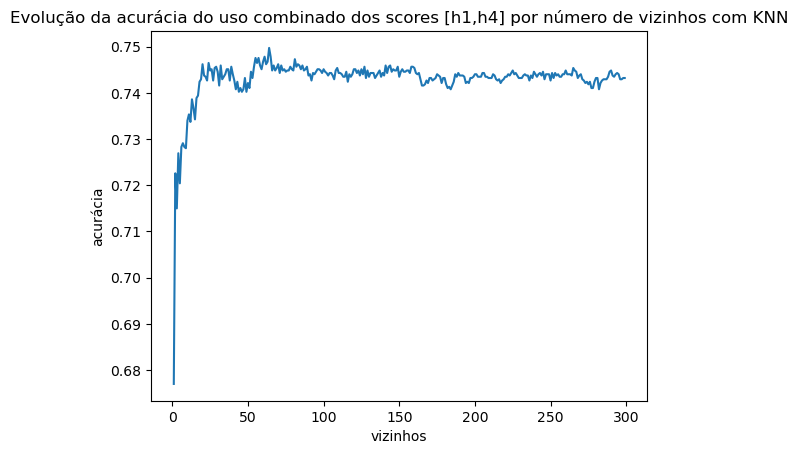

**** FIM PROCESSAMENTO :  2024-05-09 14:13:40
**** TEMPO DE PROCESSAMENTO      :  00 hr 02 min 23 seg
>>>> Melhor acurácia             :  0.749728555917481  --- para  64  vizinhos.


In [71]:
features = ['fl_consig','fl_veiculos','flagcontaativabd',
            'idade_serasa','renda','vr_exposicao_total_cartao','score_h1','score_h4']

valX = []
valY = []
maxk = 300

ti = time.time()
print("*" * 80)
print(" AVALIAÇÃO DE MODELOS COM KNN ")
print("*" * 80)
print("\n*** INÍCIO PROCESSAMENTO : ",mostra_data_hora_atual())

for k in range(1,maxk):
    acc = modelo_KNN(xl_norm,features,target,k)
    valX.append(k)
    valY.append(acc)
    
    
# Plotar o gráfico de linha
plt.plot(valX, valY)

# Adicionar rótulos aos eixos
plt.xlabel('vizinhos')
plt.ylabel('acurácia')

# Adicionar título ao gráfico
plt.title('Evolução da acurácia do uso combinado dos scores [h1,h4] por número de vizinhos com KNN')

# Mostrar o gráfico
plt.show() 

tf = time.time()
print("**** FIM PROCESSAMENTO : ",mostra_data_hora_atual())
print("**** TEMPO DE PROCESSAMENTO      : ", format_duracao(tf-ti))
print(">>>> Melhor acurácia             : ", np.max(valY), " --- para ",valX[np.argmax(valY)]," vizinhos.")

********************************************************************************
 AVALIAÇÃO DE MODELOS COM KNN 
********************************************************************************

*** INÍCIO PROCESSAMENTO :  2024-05-09 14:22:18


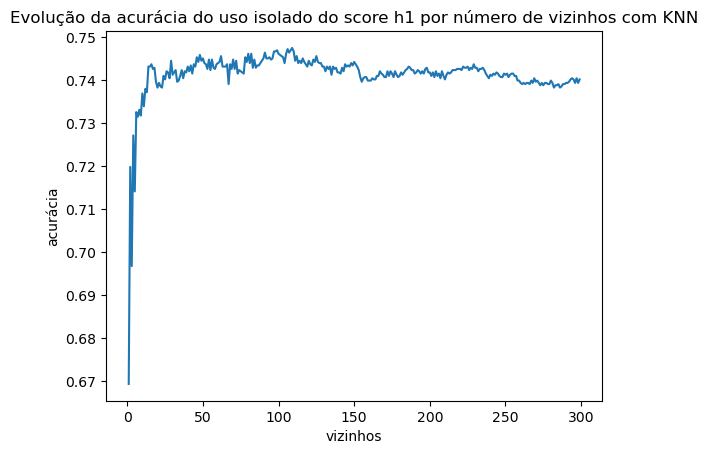

**** FIM PROCESSAMENTO :  2024-05-09 14:24:34
**** TEMPO DE PROCESSAMENTO      :  00 hr 02 min 15 seg
>>>> Melhor acurácia             :  0.747557003257329  --- para  109  vizinhos.


In [72]:
features = ['fl_consig','fl_veiculos','flagcontaativabd',
            'idade_serasa','renda','vr_exposicao_total_cartao','score_h1']

valX = []
valY = []
maxk = 300

ti = time.time()
print("*" * 80)
print(" AVALIAÇÃO DE MODELOS COM KNN ")
print("*" * 80)
print("\n*** INÍCIO PROCESSAMENTO : ",mostra_data_hora_atual())

for k in range(1,maxk):
    acc = modelo_KNN(xl_norm,features,target,k)
    valX.append(k)
    valY.append(acc)
    
    
# Plotar o gráfico de linha
plt.plot(valX, valY)

# Adicionar rótulos aos eixos
plt.xlabel('vizinhos')
plt.ylabel('acurácia')

# Adicionar título ao gráfico
plt.title('Evolução da acurácia do uso isolado do score h1 por número de vizinhos com KNN')

# Mostrar o gráfico
plt.show() 

tf = time.time()
print("**** FIM PROCESSAMENTO : ",mostra_data_hora_atual())
print("**** TEMPO DE PROCESSAMENTO      : ", format_duracao(tf-ti))
print(">>>> Melhor acurácia             : ", np.max(valY), " --- para ",valX[np.argmax(valY)]," vizinhos.")

********************************************************************************
 AVALIAÇÃO DE MODELOS COM KNN 
********************************************************************************

*** INÍCIO PROCESSAMENTO :  2024-05-09 17:28:50


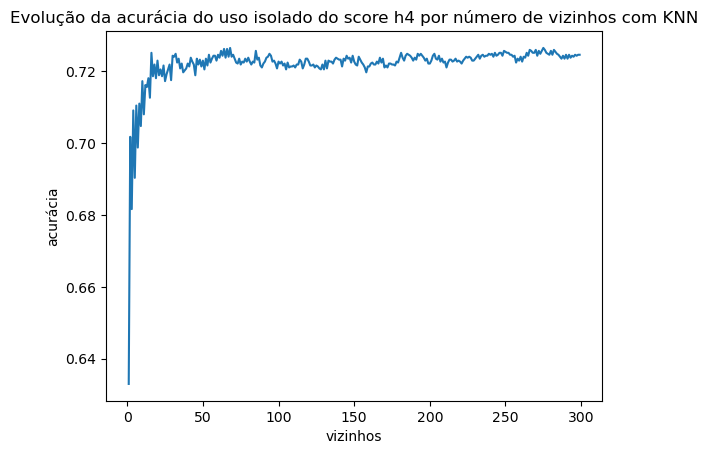

**** FIM PROCESSAMENTO :  2024-05-09 17:30:59
**** TEMPO DE PROCESSAMENTO      :  00 hr 02 min 09 seg
>>>> Melhor acurácia             :  0.7263843648208469  --- para  68  vizinhos.


In [94]:
features = ['fl_consig','fl_veiculos','flagcontaativabd',
            'idade_serasa','renda','vr_exposicao_total_cartao','score_h4']

valX = []
valY = []
maxk = 300

ti = time.time()
print("*" * 80)
print(" AVALIAÇÃO DE MODELOS COM KNN ")
print("*" * 80)
print("\n*** INÍCIO PROCESSAMENTO : ",mostra_data_hora_atual())

for k in range(1,maxk):
    acc = modelo_KNN(xl_norm,features,target,k)
    valX.append(k)
    valY.append(acc)
    
    
# Plotar o gráfico de linha
plt.plot(valX, valY)

# Adicionar rótulos aos eixos
plt.xlabel('vizinhos')
plt.ylabel('acurácia')

# Adicionar título ao gráfico
plt.title('Evolução da acurácia do uso isolado do score h4 por número de vizinhos com KNN')

# Mostrar o gráfico
plt.show() 

tf = time.time()
print("**** FIM PROCESSAMENTO : ",mostra_data_hora_atual())
print("**** TEMPO DE PROCESSAMENTO      : ", format_duracao(tf-ti))
print(">>>> Melhor acurácia             : ", np.max(valY), " --- para ",valX[np.argmax(valY)]," vizinhos.")

In [83]:
def modelo_NN(df,features,target):

    X = df[features] 
    y = df[target]    

    # Dividir os dados em conjuntos de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Criar o modelo de rede neural - camada de entrada, 1 camada oculta, camada de saída
    model = Sequential()
    model.add(Dense(8, input_dim=8, activation='relu'))  # Camada oculta com 8 neurônios e função de ativação ReLU
    model.add(Dense(1, activation='sigmoid'))  # Camada de saída com 1 neurônio e função de ativação sigmóide

    # Compilar o modelo
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Treinar o modelo usando massa de treinamento - desabilitar saida intermediaria
    model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=1)

    # Avaliar o modelo
    _, acc = model.evaluate(X_test, y_test)
    
    return acc

In [105]:
def modelo_NN_grafico_2scores(df,features,target):

    X = df[features] 
    y = df[target]    

    # Dividir os dados em conjuntos de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Criar o modelo de rede neural - camada de entrada, 1 camada oculta, camada de saída
    model = Sequential()
    model.add(Dense(8, input_dim=8, activation='relu'))  # Camada oculta com 8 neurônios e função de ativação ReLU
    model.add(Dense(1, activation='sigmoid'))  # Camada de saída com 1 neurônio e função de ativação sigmóide

    # Compilar o modelo
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    
    acuracias = []
    epocas = []

    # Treinar o modelo
    for epoch in range(1, 51):  # 50 épocas
        model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=0)  # Treinamento de 1 em 1 época
        _, acc = model.evaluate(X_test, y_test, verbose=0)
        #print('Época {}, Acurácia: {:.2f}'.format(epoch, acc * 100))
        acuracias.append(acc)
        epocas.append(epoch)

    # Plotar o gráfico de acurácia
    plt.plot(epocas, acuracias)
    plt.title('Acurácia durante o treinamento')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.show()
    
    print(">>>> Melhor acurácia             : ", np.max(acuracias), " --- para ",epocas[np.argmax(acuracias)]," épocas.")
    
    return 

In [106]:
def modelo_NN_grafico_1score(df,features,target):

    X = df[features] 
    y = df[target]    

    # Dividir os dados em conjuntos de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Criar o modelo de rede neural - camada de entrada, 1 camada oculta, camada de saída
    model = Sequential()
    model.add(Dense(8, input_dim=7, activation='relu'))  # Camada oculta com 8 neurônios e função de ativação ReLU
    model.add(Dense(1, activation='sigmoid'))  # Camada de saída com 1 neurônio e função de ativação sigmóide

    # Compilar o modelo
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    
    acuracias = []
    epocas = []

    # Treinar o modelo
    for epoch in range(1, 51):  # 50 épocas
        model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=0)  # Treinamento de 1 em 1 época
        _, acc = model.evaluate(X_test, y_test, verbose=0)
        #print('Época {}, Acurácia: {:.2f}'.format(epoch, acc * 100))
        acuracias.append(acc)
        epocas.append(epoch)

    # Plotar o gráfico de acurácia
    plt.plot(epocas, acuracias)
    plt.title('Acurácia durante o treinamento')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.show()
    
    print(">>>> Melhor acurácia             : ", np.max(acuracias), " --- para ",epocas[np.argmax(acuracias)]," épocas.")
    
    return 

**************************************************************************************************************
 AVALIAÇÃO DE MODELOS COM REDE NEURAL - EVOLUÇÃO DA ACURACIA PARA O USO COMBINADO DOS SCORES [h1,h4] POR EPOCA
**************************************************************************************************************

*** INÍCIO PROCESSAMENTO :  2024-05-09 18:17:55


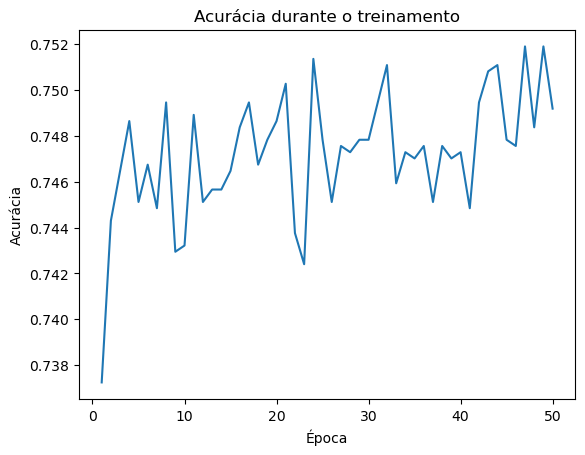

>>>> Melhor acurácia             :  0.7519001364707947  --- para  47  épocas.
**** FIM PROCESSAMENTO :  2024-05-09 18:26:09
**** TEMPO DE PROCESSAMENTO      :  00 hr 08 min 14 seg


In [103]:
features = ['fl_consig','fl_veiculos','flagcontaativabd',
            'idade_serasa','renda','vr_exposicao_total_cartao','score_h1','score_h4']

ti = time.time()
print("*" * 110)
print(" AVALIAÇÃO DE MODELOS COM REDE NEURAL - EVOLUÇÃO DA ACURACIA PARA O USO COMBINADO DOS SCORES [h1,h4] POR EPOCA")
print("*" * 110)
print("\n*** INÍCIO PROCESSAMENTO : ",mostra_data_hora_atual())

acc = modelo_NN_grafico_2scores(xl_norm,features,target)

tf = time.time()
print("**** FIM PROCESSAMENTO : ",mostra_data_hora_atual())
print("**** TEMPO DE PROCESSAMENTO      : ", format_duracao(tf-ti))


**************************************************************************************************************
 AVALIAÇÃO DE MODELOS COM REDE NEURAL - EVOLUÇÃO DA ACURACIA PARA O USO DO SCORE h1 ISOLADO, POR EPOCA
**************************************************************************************************************

*** INÍCIO PROCESSAMENTO :  2024-05-09 18:33:50


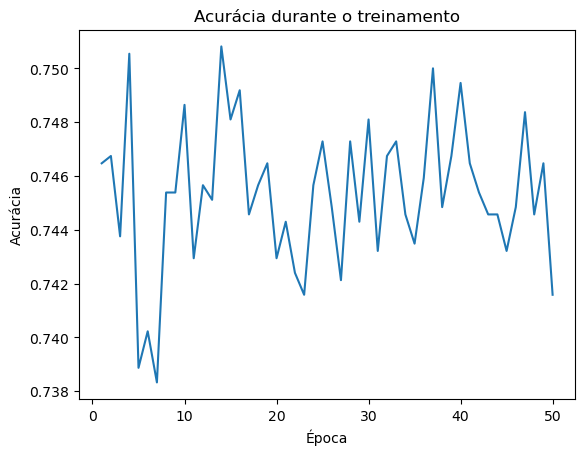

>>>> Melhor acurácia             :  0.7508143186569214  --- para  14  épocas.
**** FIM PROCESSAMENTO :  2024-05-09 18:42:10
**** TEMPO DE PROCESSAMENTO      :  00 hr 08 min 19 seg


In [107]:
features = ['fl_consig','fl_veiculos','flagcontaativabd',
            'idade_serasa','renda','vr_exposicao_total_cartao','score_h1']

ti = time.time()
print("*" * 110)
print(" AVALIAÇÃO DE MODELOS COM REDE NEURAL - EVOLUÇÃO DA ACURACIA PARA O USO DO SCORE h1 ISOLADO, POR EPOCA")
print("*" * 110)
print("\n*** INÍCIO PROCESSAMENTO : ",mostra_data_hora_atual())

acc = modelo_NN_grafico_1score(xl_norm,features,target)

tf = time.time()
print("**** FIM PROCESSAMENTO : ",mostra_data_hora_atual())
print("**** TEMPO DE PROCESSAMENTO      : ", format_duracao(tf-ti))


**************************************************************************************************************
 AVALIAÇÃO DE MODELOS COM REDE NEURAL - EVOLUÇÃO DA ACURACIA PARA O USO DO SCORE h4 ISOLADO, POR EPOCA
**************************************************************************************************************

*** INÍCIO PROCESSAMENTO :  2024-05-09 19:02:05


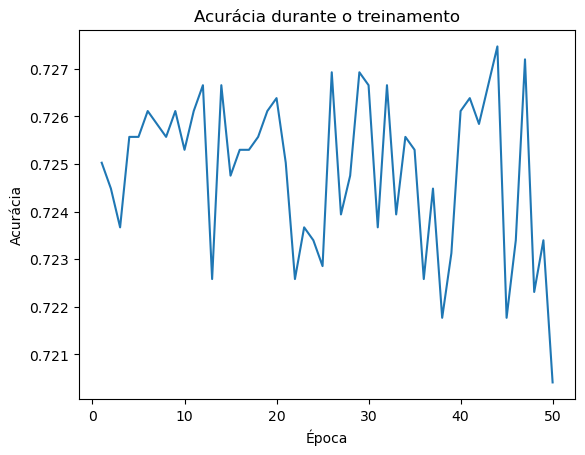

>>>> Melhor acurácia             :  0.7274701595306396  --- para  44  épocas.
**** FIM PROCESSAMENTO :  2024-05-09 19:10:34
**** TEMPO DE PROCESSAMENTO      :  00 hr 08 min 28 seg


In [109]:
features = ['fl_consig','fl_veiculos','flagcontaativabd',
            'idade_serasa','renda','vr_exposicao_total_cartao','score_h4']

ti = time.time()
print("*" * 110)
print(" AVALIAÇÃO DE MODELOS COM REDE NEURAL - EVOLUÇÃO DA ACURACIA PARA O USO DO SCORE h4 ISOLADO, POR EPOCA")
print("*" * 110)
print("\n*** INÍCIO PROCESSAMENTO : ",mostra_data_hora_atual())

acc = modelo_NN_grafico_1score(xl_norm,features,target)

tf = time.time()
print("**** FIM PROCESSAMENTO : ",mostra_data_hora_atual())
print("**** TEMPO DE PROCESSAMENTO      : ", format_duracao(tf-ti))
